In [1]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

import glob
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import json
from tqdm import tqdm_notebook


class PaletteExtract:
    def __init__(self):
        self.account_name_ = ''
        self.palette_dict_ = {}
        self.log_list_ = []
        pass
    
    def set_account_name(self, account_name):
        print(f'Changed the account name from "{self.account_name_}" to "{account_name}"...')
        self.account_name_ = account_name
    
    def set_palette_dict(self, limit_num=None, account_name=None):
        if account_name == None:
            account_name = self.account_name_
        else:
            self.account_name_ = account_name
        
        dir_path = f'../data/pictures_{account_name}/*.png'
        file_path_list = glob.glob(dir_path)
        file_path_list = [name.replace('\\','/') for name in file_path_list]
        
        if isinstance(limit_num, int):
            file_path_list = file_path_list[:limit_num]
        
        msg = f'>>> Setting palette dict of {len(file_path_list)} files...\n'
        print(msg)
        self.log_list_.append(msg)
        for idx, file_path in tqdm_notebook(enumerate(file_path_list), total=len(file_path_list)):
            try:
                img = self.load_image(file_path)  # 1. Load image
                bbox, _, _ = self.detect_person(img, idx, file_path)  # 2. Detect the object 'person' from image
                background_list = self.background_extract(img, bbox, col_num=3)  # 3. background extract
                foreground_list = self.foreground_extract(img, bbox, col_num=2)  # 4. foreground extract
                
                file_name = file_path.split('/')[-1]
                self.palette_dict_[file_name] = (background_list, foreground_list)  # Add palette pair into palette_dict
            
            except Exception as e:
                msg = f'>>> Error in {idx+1}th file : {file_path}\n\t{e}\n'
                print(msg)
                self.log_list_.append(msg)
            
            if idx+1 % 30 == 0:
                print(f'>>> {idx+1}th file completed...')
        msg = '>>> Finished setting palette dict!\n'
        print(msg)
        self.log_list_.append(msg)
        


    # set_palette_dict - 1
    def load_image(self, file_path):
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img


    # set_palette_dict - 2
    def detect_person(self, img, idx, file_path):
        bbox, label, conf = cv.detect_common_objects(img)

        if label.count('person') > 1:   # Exceptional case : 2 or more persons are detected
            msg = f'>>> Warning : More than 1 person is detected from the given picture!\n' +\
                  f'>>> Warning in {idx+1}th file : {file_path}\n'
            print(msg)
            self.log_list_.append(msg)
            idx = label.index('person')
            bbox = [bbox[idx]]
            label = [label[idx]]
            conf = [conf[idx]]
        elif label.count('person') == 1:   # Ideal case : only one main preson is detected
            idx = label.index('person')
            bbox = [bbox[idx]]
            label = [label[idx]]
            conf = [conf[idx]]
        else:   # Exceptional case : No person is detected
            msg = f'>>> Error : No person is detected from the given picture!'
            print(msg)
            self.log_list_.append(msg)
            raise Exception
        return bbox, label, conf


    # set_palette_dict - 3
    def background_extract(self, img, bbox, col_num=3):
        # Preprocess
        x, y, x_end, y_end = bbox[0]
        top = img[ :y , : ]
        bottom = img[ y_end: , : ]
        left = img[ y:y_end , :x ]
        right = img[ y:y_end , x_end: ]

        top    = top.reshape(    top.shape[0]    * top.shape[1], 3)
        bottom = bottom.reshape( bottom.shape[0] * bottom.shape[1], 3)
        left   = left.reshape(   left.shape[0]   * left.shape[1], 3)
        right  = right.reshape(  right.shape[0]  * right.shape[1], 3)
        
        img_new = np.concatenate((top, bottom, left, right))
        
        # Extract & Arrange colors
        clt = KMeans(n_clusters = 10)
        clt.fit(img_new)
        arranged_centers_arr = self.arrange_cluster_centers(clt)  # arrange colors by frequency
        background_list = arranged_centers_arr.tolist()[:col_num]  # save only k colors
        
        return background_list


    # set_palette_dict - 4
    def foreground_extract(self, img, bbox, col_num=2):
        # Preprocess
        x, y, x_end, y_end = bbox[0]
        y_edge = int((y_end - y) * 0.2)
        x_edge = int((x_end - x) * 0.2)

        img_new = img[ (y+y_edge):(y_end-y_edge), (x+x_edge):(x_end-x_edge) ]
        img_new = img_new.reshape((img_new.shape[0] * img_new.shape[1], 3))
        
        # Extract & Arrange colors
        clt = KMeans(n_clusters = 10)
        clt.fit(img_new)
        arranged_centers_arr = self.arrange_cluster_centers(clt)  # arrange colors by frequency
        foreground_list = arranged_centers_arr.tolist()[:col_num]  # save only k colors
        
        return foreground_list
    
    
    def arrange_cluster_centers(self, clt):
            lb_counts = Counter(clt.labels_)

            tmp_dict = {}
            for idx, pixel in enumerate(clt.cluster_centers_):
                tmp_dict[ lb_counts[idx] ] = pixel  # { frequency of label : color of label } mapping

            centers_aranged_dict = dict(sorted(tmp_dict.items(), reverse=True))  # arrange the dict according to key (frequency of label)

            arranged_centers_arr = np.array(list(centers_aranged_dict.values()))  # pack colors into one array
            arranged_centers_arr = arranged_centers_arr.round().astype("uint8")  # tranform the type to integer
            return arranged_centers_arr
    
    
    def save_json(self, output_name=None):
        if output_name == None:
            output_name = self.account_name_
        
        save_path = f'../data/{output_name}.json'
        with open(save_path, 'w') as json_file:
            json.dump(self.palette_dict_, json_file)
        msg = f'>>> Successfully saved {len(self.palette_dict_.keys())} results into json!\n'
        print(msg)
        self.log_list_.append(msg)
    
    
    def save_log(self, output_name=None):
        if output_name == None:
            output_name = self.account_name_
        save_path = f'../data/{output_name}_ExtractLog.txt'
        
        with open(save_path, 'w') as fp:
            log = '\n'.join(self.log_list_)
            fp.write(log)
        print('>>> Finished Saving ExtractLog!\n')


    def visualize_results(self, results_num=1):
        key_list = list(self.palette_dict_.keys())
        if results_num > len(key_list):
            print(f'>>> Warning : There are only {len(key_list)} results...')
            results_num = len(key_list)
        key_list = key_list[:results_num]
        
        for idx, key in enumerate(key_list):
            self.visualize_one_result(key)
            
            if (idx+1) % 3 == 0:
                mes = input('Press Enter to show next 3 results (input -1 to exit) >>> ')
                if mes == '-1':
                    break
        pass
    
    
    def visualize_one_result(self, key):
        # Prepare values
        file_path = f'../data/pictures_{self.account_name_}/{key}'
        img = self.load_image(file_path)
        
        background_arr = self.palette_dict_[key][0]
        foreground_arr = self.palette_dict_[key][1]
        
        background_arr = np.expand_dims(background_arr, 0)
        foreground_arr = np.expand_dims(foreground_arr, 0)
        
        # Visualize the values
        fig = plt.figure(constrained_layout=True, figsize=(7, 4))
        spec = fig.add_gridspec(2, 4)

        axe1 = fig.add_subplot(spec[:, :2]) # img
        axe1.imshow(img)
        axe2 = fig.add_subplot(spec[0, 2:]) # background_arr
        axe2.imshow(background_arr)
        axe2.set_title('background_colors', size=15)
        axe3 = fig.add_subplot(spec[1, 2:]) # foreground_arr
        axe3.imshow(foreground_arr)
        axe3.set_title('foreground_colors', size=15)
        plt.show()
    
    
    def __str__(self):
        return f"account_name : {self.account_name_}, number of results : {len(self.palette_dict_)}"

Using TensorFlow backend.


In [2]:
import time

pal_extr = PaletteExtract()

start_time = time.time()
pal_extr.set_palette_dict(account_name='voyagefox_')
end_time = time.time()

pal_extr.save_json()
pal_extr.save_log()

>>> Setting palette dict of 53 files...



/home/ubuntu/anaconda3/envs/pj1_sam/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


>>> Warning : More than 1 person is detected from the given picture!
>>> Warning in 2th file : ../data/pictures_voyagefox_/voyagefox__043_4540Likes.png

>>> Error : No person is detected from the given picture!
>>> Error in 3th file : ../data/pictures_voyagefox_/voyagefox__103_8229Likes.png
	

>>> Error : No person is detected from the given picture!
>>> Error in 6th file : ../data/pictures_voyagefox_/voyagefox__114_5735Likes.png
	

>>> Error : No person is detected from the given picture!
>>> Error in 12th file : ../data/pictures_voyagefox_/voyagefox__106_5520Likes.png
	

>>> Error : No person is detected from the given picture!
>>> Error in 14th file : ../data/pictures_voyagefox_/voyagefox__038_5367Likes.png
	

>>> Error : No person is detected from the given picture!
>>> Error in 15th file : ../data/pictures_voyagefox_/voyagefox__042_9357Likes.png
	

>>> Error : No person is detected from the given picture!
>>> Error in 16th file : ../data/pictures_voyagefox_/voyagefox__134_6581Like

extract time : 1971.0824 sec 

account_name : voyagefox_, number of results : 32 

===== Visualization =====


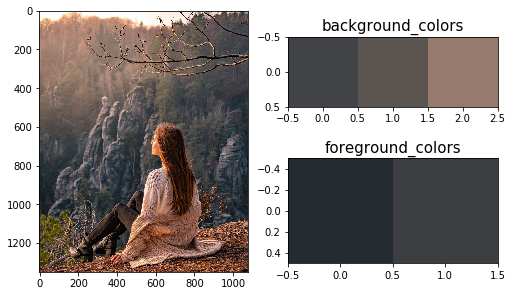

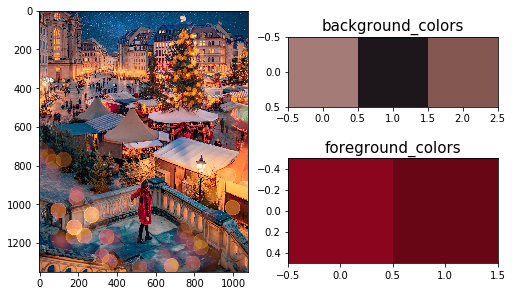

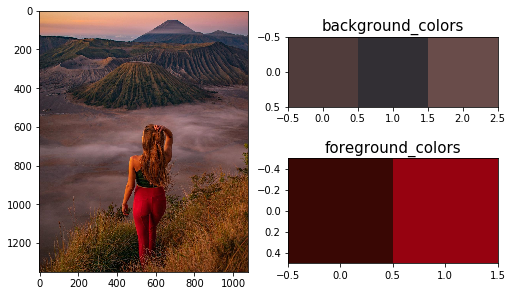

Press Enter to show next 3 results (input -1 to exit) >>> 


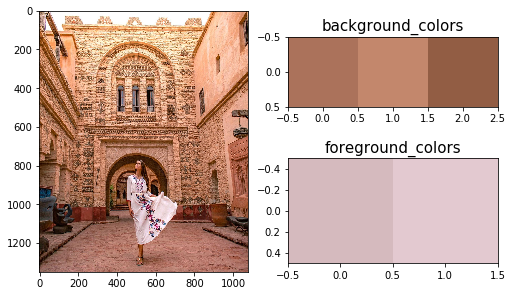

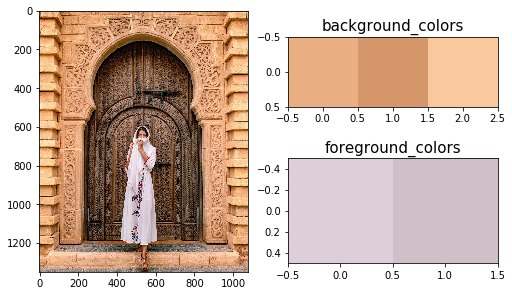

In [3]:
print(f'extract time : {end_time - start_time:.4f} sec', '\n')
print(pal_extr, '\n')

print('===== Visualization =====')
pal_extr.visualize_results(results_num=5)